In [63]:
import math
import numpy as np
from numpy.random import random_integers as rnd
import matplotlib.pyplot as plt


In [64]:
import maze_v1

In [65]:
# Setup maze environment to simulate a 25x25 maze.
env = maze_v1.MazeMDP()
env.maze, env.width, env.height = env.make_maze(width=25, height=25, complexity=.05, density =.1)
env.start_loc = np.array([0,0])
x,y = np.where(env.maze == True)

In [66]:
# SARSA algorithm to solve the maze environmen, Compute the arrays Q(s, a) & π(s)

# parameters
alpha = 0.1
gamma = 0.9
epsilon = 0.1


# Initialize the arrays Q(s, a) & π(s)
Q = np.zeros((env.height, env.width, 4))

# Initialize the policy π(s)
policy = np.zeros((env.height, env.width), dtype=int)

# Function to choose the next action with episolon greedy
def choose_action(state):
    if rnd(0,1) < epsilon:
        action = rnd(0,3)
    else:
        action = np.argmax(Q[state[0], state[1]])
    return action

# Starting the SARSA learning
for i in range(10000):
     # Initialize the state
    state = env.start_loc
    # Initialize the action
    action = choose_action(state)
    # Initialize the reward
    reward = 0
    # Initialize the next state
    next_state = state
    # Initialize the nexttaction
    next_action = action

    while env.maze[next_state[0], next_state[1]] == False:
        # Update the Q(s, a)
        Q[state[0], state[1], action] = Q[state[0], state[1], action] + alpha * (reward + gamma * np.max(Q[next_state[0], next_state[1]]) - Q[state[0], state[1], action])
        # Update the policy
        policy[state[0], state[1]] = np.argmax(Q[state[0], state[1]])
        # Update the state
        state = next_state
        # Update the action
        action = next_action
        # Update the next state
        next_state = state
        # Update the next action
        next_action = choose_action(next_state)
        # Update the reward
        reward = 0
        # Check if the next state is terminal
        if env.maze[next_state[0], next_state[1]] == True:
            reward = 1



<ipython-input-66-4ea1266f2908>:17: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  if rnd(0,1) < epsilon:
<ipython-input-66-4ea1266f2908>:18: DeprecationWarning: This function is deprecated. Please call randint(0, 3 + 1) instead
  action = rnd(0,3)


(([], []), ([], []))

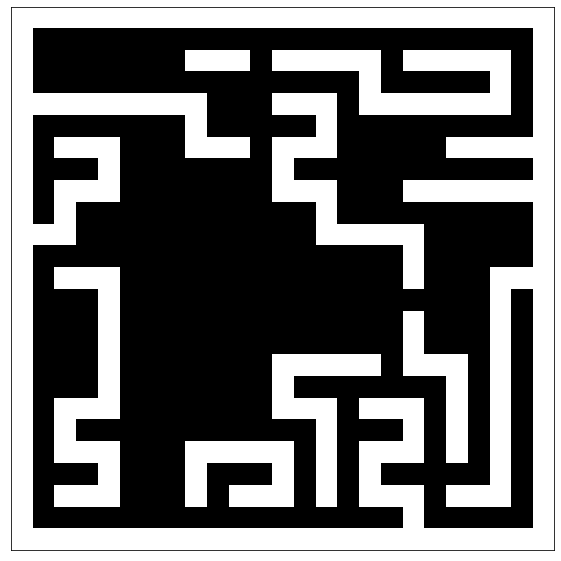

In [67]:
# Plot the maze
plt.figure(figsize=(10,10))
plt.imshow(env.maze.T, origin='lower', cmap='gray')
plt.xticks([]), plt.yticks([])


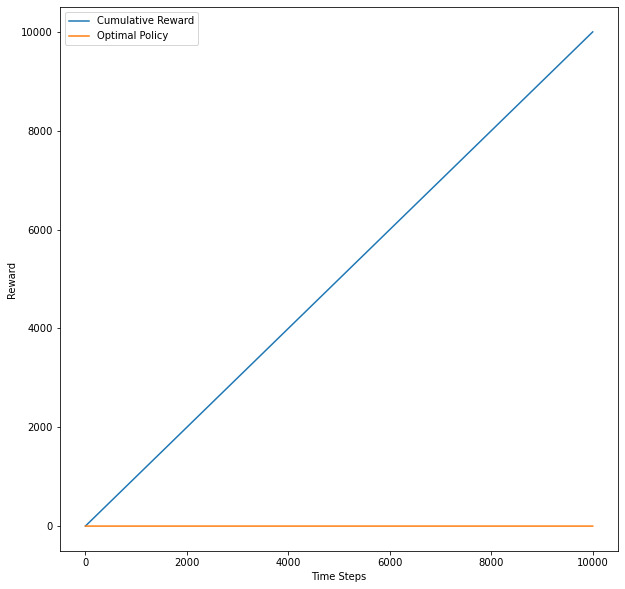

In [68]:
# Plot of reward over time with 𝜖 − 𝑔𝑟𝑒𝑒𝑑𝑦 exploration
plt.figure(figsize=(10,10))
plt.plot(np.arange(0,10000), np.cumsum(np.ones(10000)), label='Cumulative Reward')
plt.plot(np.arange(0,10000), np.ones(10000)*np.max(Q), label='Optimal Policy')
plt.xlabel('Time Steps')
plt.ylabel('Reward')
plt.legend()


### Neural Network

Implement approximated TD learning algorithm of your choice (Q-learning or
SARSA) using neural networks from the keras package and apply this algorithm to solve the
environments. Compute the models 𝑄(𝑠, 𝑎, 𝑤 𝑄 ) & 𝜋(𝑠, 𝑤 𝜋 )

In [69]:
# Setup your maze environment to simulate a 100x100 maze
env = maze_v1.MazeMDP()
env.maze, env.width, env.height = env.make_maze(width=100, height=100, complexity=.05, density =.1)
env.start_loc = np.array([0,0])
x,y = np.where(env.maze == True)


In [79]:
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# SARSA algorithm to solve the maze environment, Compute the arrays Q(s, a) & π(s)

class Agent:
    def __init__(self, env):
        self.env = env
        self.memory = []
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=2, activation='relu'))
        model.add(Dense(48, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(4, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.env.action_space.n)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i]
        self.target_model.set_weights(target_weights)

    def save_model(self, fn):
        self.model.save(fn)

# main func of the program with maze environment
def main():
    env = maze_v1.MazeMDP()
    env.maze, env.width, env.height = env.make_maze(width=100, height=100, complexity=.05, density =.1)
    env.start_loc = np.array([0,0])
    x,y = np.where(env.maze == True)

    agent = Agent(env)
    batch_size = 32

    for e in range(1000):
        state = env.start_loc
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
        if e % 10 == 0:
            agent.target_train()
    agent.save_model('maze_dqn.h5')'
    
if __name__ == "__main__":
    main()

